In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [115]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [106]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [107]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [108]:
##GPU 사용 시
device = torch.device("cpu")

In [109]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [112]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/딥러닝을 활용한 자연어 처리/공모전_제공_데이터(1차).xlsx')

### 탐색적 데이터분석(EDA)

In [113]:
data.head()

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류(우선순위 가장 높은것 선택)
0,1,6438,상담직원과 빠른연결했슴좋겠어요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
1,2,6850,안기다리고. 빨리상담되었음좋겠다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
2,3,7294,너무 오래기다리고 상담이 늦어져요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
3,4,9484,상담직원과 통화가 매우 힘들다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
4,5,10350,상담받으려면오래기다리는게불편함,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NO                    1000 non-null   int64  
 1   NO2                   1000 non-null   int64  
 2   발화                    1000 non-null   object 
 3   발화1                   1000 non-null   object 
 4   발화1의 우선순위             1000 non-null   int64  
 5   발화2                   32 non-null     object 
 6   발화2의 우선순위             32 non-null     float64
 7   발화3                   3 non-null      object 
 8   발화3의 우선순위             3 non-null      float64
 9   최종분류(우선순위 가장 높은것 선택)  1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.2+ KB


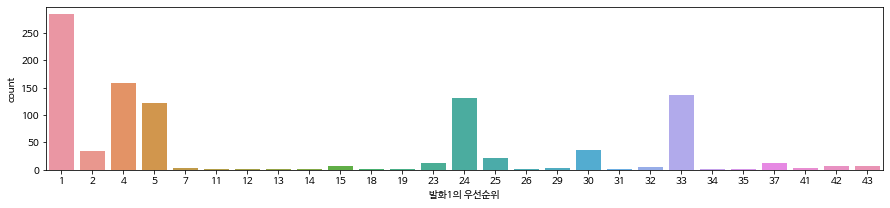

In [ ]:
countplt, ax = plt.subplots(figsize = (15,3))
plt.rc('font', family='NanumBarunGothic') 
sns.countplot(data['발화1의 우선순위'])

In [ ]:
str_cols = [col for col in data.columns if data[col].dtype in ['float64']]
for col in str_cols:
    print('{}:'.format(col),data[col].nunique())

발화2의 우선순위: 9
발화3의 우선순위: 2


## 데이터전처리

In [ ]:
data = data.drop(columns=['NO', 'NO2', '발화1', '발화2', '발화3'])

In [ ]:
min_data = []
for i in range(len(data)):
  a = int(min(data.iloc[i, [1, 2, 3]]).round(0))
  min_data.append(a)

data['label'] = min_data

In [ ]:
data = data.drop(columns=['발화1의 우선순위', '발화2의 우선순위', '발화3의 우선순위', '최종분류(우선순위 가장 높은것 선택)'])

In [ ]:
len(data['label'].unique())

27

In [ ]:
data['label'].unique()

array([ 5,  4, 42, 41, 37, 35, 34, 33, 32, 31, 30, 29, 26, 25, 43,  2,  1,
       24, 23, 19, 18, 15, 14, 13, 12, 11,  7])

In [ ]:
label_dic = {}
t = 0
for num in data['label'].unique():
    label_dic[num] = t
    t = t+1

In [ ]:
data['label'].apply(lambda x: label_dic[x])

0       0
1       0
2       0
3       0
4       0
       ..
995    25
996    26
997    26
998    26
999    26
Name: label, Length: 1000, dtype: int64

In [ ]:
data.head()

,발화,label
0,상담직원과 빠른연결했슴좋겠어요,5
1,안기다리고. 빨리상담되었음좋겠다,5
2,너무 오래기다리고 상담이 늦어져요,5
3,상담직원과 통화가 매우 힘들다,5
4,상담받으려면오래기다리는게불편함,5


In [ ]:
#발화데이터 정규화
data['발화'] = data['발화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [ ]:
result_data = data.copy()

In [ ]:
result_data['label'] = result_data['label'].apply(lambda x: label_dic[x])

In [ ]:
data_list = []
for q, label in zip(result_data['발화'], result_data['label'])  :
    data_ = []
    data_.append(q)
    data_.append(str(label))

    data_list.append(data_)

## 모델링

In [ ]:
# Train / Test set 분리
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_list, test_size=0.2, random_state=42)
print("train shape is:", len(train))
print("test shape is:", len(test))

train shape is: 800
test shape is: 200


In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair) 

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# Setting parameters
max_len = 64 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 1
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [ ]:
data_train = BERTDataset(train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 27, # softmax 사용 <- binary일 경우는 2
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
# 옵티마이저 선언
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
# 학습 평가 지표인 accuracy 계산 -> 얼마나 타겟값을 많이 맞추었는가
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
train_dataloader

In [ ]:
t=0
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
    t = t+1

  0%|          | 0/800 [00:00<?, ?it/s]

In [114]:
# 모델 학습 시작
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.5306334495544434 train acc 0.0
epoch 1 batch id 201 loss 0.046537481248378754 train acc 0.6766169154228856
epoch 1 batch id 401 loss 0.004422526806592941 train acc 0.7182044887780549
epoch 1 batch id 601 loss 6.116814136505127 train acc 0.7321131447587355
epoch 1 train acc 0.75125


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 test acc 0.73


  0%|          | 0/800 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.0025744650047272444 train acc 1.0
epoch 2 batch id 201 loss 0.06276226788759232 train acc 0.835820895522388
epoch 2 batch id 401 loss 0.004253626335412264 train acc 0.827930174563591
epoch 2 batch id 601 loss 7.0687479972839355 train acc 0.8352745424292846
epoch 2 train acc 0.8425


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 2 test acc 0.78


  0%|          | 0/800 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.0012997282901778817 train acc 1.0
epoch 3 batch id 201 loss 0.00373582704924047 train acc 0.8407960199004975
epoch 3 batch id 401 loss 0.0012949660886079073 train acc 0.85785536159601
epoch 3 batch id 601 loss 8.086552619934082 train acc 0.8668885191347754
epoch 3 train acc 0.87625


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 3 test acc 0.79


  0%|          | 0/800 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.001211028778925538 train acc 1.0
epoch 4 batch id 201 loss 0.002771110739558935 train acc 0.8955223880597015
epoch 4 batch id 401 loss 0.004210180137306452 train acc 0.8977556109725686
epoch 4 batch id 601 loss 5.231504917144775 train acc 0.9001663893510815
epoch 4 train acc 0.90625


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 4 test acc 0.795


  0%|          | 0/800 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.001341634662821889 train acc 1.0
epoch 5 batch id 201 loss 0.0025933701545000076 train acc 0.900497512437811
epoch 5 batch id 401 loss 0.0018542492762207985 train acc 0.912718204488778
epoch 5 batch id 601 loss 6.227794647216797 train acc 0.908485856905158
epoch 5 train acc 0.91


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 5 test acc 0.805


In [116]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
            test_eval.append(label_swap[np.argmax(logits)])

    return test_eval[0]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
